<a href="https://colab.research.google.com/github/geoffwoollard/learn_cryoem_math/blob/master/nb/topology_representing_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal
* implement topology representing network in 3D. 
* Visualize how it works for different hyperparameters
* demonstrate it working for different simple shapes (Gaussian blobs)

# Resources
* Martinetz, T., & Schulten, K. (1994). Topology representing networks. Neural Networks, 7(3), 507–522. http://doi.org/10.1016/0893-6080(94)90109-0
* Zhang, Y., Krieger, J., Mikulska-Ruminska, K., Kaynak, B., Sorzano, C. O. S., Carazo, J. M., … Bahar, I. (2021). State-dependent sequential allostery exhibited by chaperonin TRiC/CCT revealed by network analysis of Cryo-EM maps. Progress in Biophysics and Molecular Biology, 160, 104–120. http://doi.org/10.1016/j.pbiomolbio.2020.08.006

# Setup

In [3]:
import numpy as np
import pandas as pd
from scipy.stats import rankdata
import matplotlib.pyplot as plt
def doplt(arr): return(plt.imshow(arr,cmap='gray'))

In [4]:
!wget https://raw.githubusercontent.com/geoffwoollard/learn_cryoem_math/master/src/coords.py
!wget https://raw.githubusercontent.com/geoffwoollard/learn_cryoem_math/master/src/gauss_forward_model.py
import coords, gauss_forward_model

--2021-04-19 04:27:42--  https://raw.githubusercontent.com/geoffwoollard/learn_cryoem_math/master/src/coords.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2483 (2.4K) [text/plain]
Saving to: ‘coords.py.3’

coords.py.3         100%[===================>]   2.42K  --.-KB/s    in 0s      

2021-04-19 04:27:42 (30.8 MB/s) - ‘coords.py.3’ saved [2483/2483]

--2021-04-19 04:27:42--  https://raw.githubusercontent.com/geoffwoollard/learn_cryoem_math/master/src/gauss_forward_model.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2148

# 1D

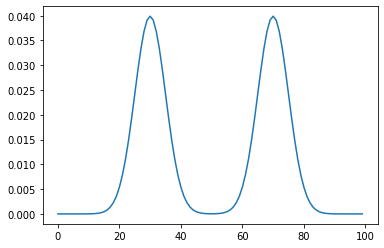

In [231]:
N=100
coords_1d = np.arange(-N//2,N//2)
sigma=5
a = -0.5/sigma**2
arr = np.exp(a*(coords_1d-20)**2)
arr += np.exp(a*(coords_1d+20)**2)

arr /= arr.sum()
pd.Series(arr).plot()

sample $\vec r_m(0)$ from $P(\vec r_i)$

In [241]:
arr_flat = arr.flatten()
arr_idx = np.arange(arr_flat.shape[0])
M=10
np.random.seed(0)
samples_idx = np.random.choice(arr_idx,size=M,replace=False,p=arr_flat) # replace or not... not sure
samples_idx

array([64, 69, 66, 63, 35, 67, 36, 74, 77, 34])

sample $\vec r$ from $P(\vec r_i)$

In [242]:
r_idx = np.random.choice(arr_idx,p=arr_flat) 
r = coords_1d[r_idx]

determine $d(\vec r_m,\vec r) \ \forall \ m$

In [243]:
d=1
rm0 = coords_1d[samples_idx]
dist = np.sqrt((r - rm0)**2) # usually sum over xyz
dist

array([ 7.,  2.,  5.,  8., 36.,  4., 35.,  3.,  6., 37.])

Sort distances into ranking

In [244]:
rank = rankdata(dist)-1
rank

array([5., 0., 3., 6., 8., 2., 7., 1., 4., 9.])

Update $\vec r_m  \ \forall \ m$ 

In [245]:
e0=0.3
ef=0.05
l0=0.2*M
lf = 0.5
tf = 200*M


In [246]:
rms = np.zeros((tf+1,d,M))
rms[0] = rm0
rs = np.zeros((tf+1,d))

In [247]:
for t in range(tf):
  r_idx = np.random.choice(arr_idx,p=arr) 
  r = coords_1d[r_idx]
  rs[t]=r
  dist = np.sqrt((r - rm)**2)
  rank = rankdata(dist)-1

  l = l0*(lf/l0)**(t/tf)
  e = e0*(ef/e0)**(t/tf)
  rms[t+1] = rms[t] + e*np.exp(-rank/l)*(r-rms[t])
  rm=rms[t+1]

  


We can visualize the pseudo atoms move over the different iterations

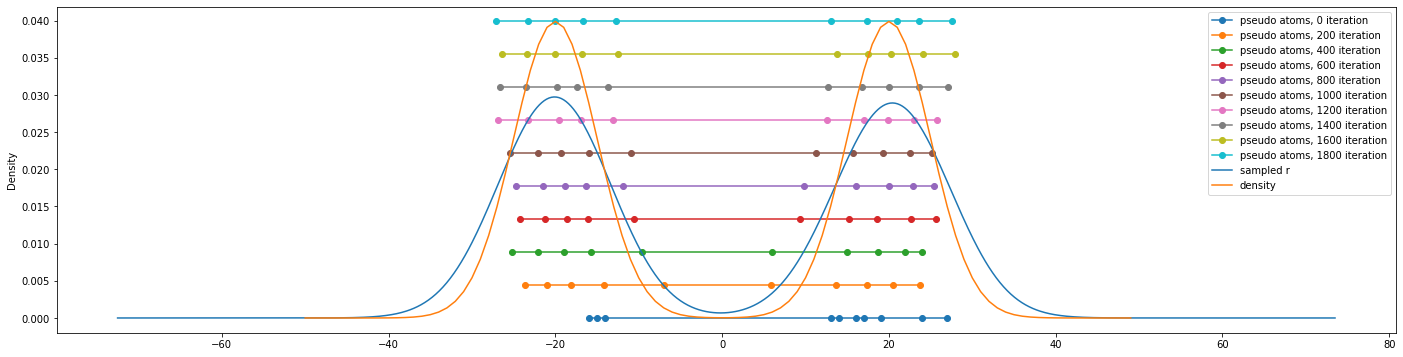

In [248]:
rm_plot = pd.Series(np.ones(M))
plt.figure(figsize=(24,6))
max_plot = arr.max()
ts = [t for t in range(0,tf,tf//10)]
for idx,t in enumerate(ts):
  rm = rms[t].flatten()
  rm_plot.index = rm[np.argsort(rm,axis=None)]
  height = idx/(len(ts)-1)*max_plot
  pd.Series(height*rm_plot).plot(marker='o',legend=True,label='pseudo atoms, %i iteration'%t)

pd.Series(rs.flatten()).plot.kde(legend=True,label='sampled r')
sr = pd.Series(arr.flatten())
sr.index = coords_1d
sr.plot(legend=True,label='density')



We can follow one node

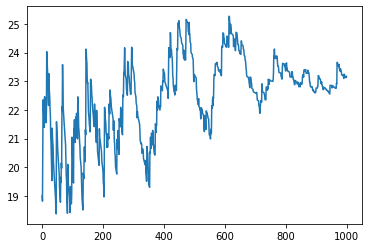

In [239]:
pd.Series(rms[:,:,1].flatten()).plot()

# 2D

In [9]:
N=64
coords_1d = np.arange(-N//2,N//2)
sigma=3

xy = coords.coords_n_by_d(coords_1d,d=2)
xy[:,[0,1]] = xy[:,[1,0]]

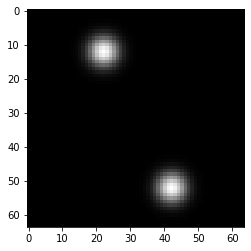

In [614]:
xv,yv = np.meshgrid(coords_1d,coords_1d)
arr = gauss_forward_model.make_gauss_2d(xv,yv,mu=[-10,-20],sigma=sigma)
arr += gauss_forward_model.make_gauss_2d(xv,yv,mu=[10,20],sigma=sigma)
arr /= arr.sum()
doplt(arr)

In [615]:
arr_flat = arr.flatten()
arr_idx = np.arange(arr_flat.shape[0])
np.random.seed(1)
M=500
samples_idx = np.random.choice(arr_idx,size=M,replace=True,p=arr_flat) # replace or not... not sure

Let's quickly check the indexing is right (with flattening and reshaping)

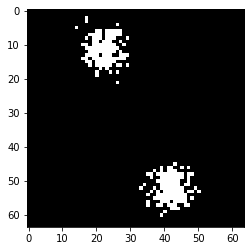

In [616]:
arr_empty = np.zeros(N*N)
arr_empty[samples_idx]=1
doplt(arr_empty.reshape(N,N))

In [617]:
r_idx = np.random.choice(arr_idx,p=arr_flat) 
r = xy[r_idx]

rm0 = xy[samples_idx]
dist = np.sqrt(((r - rm0)**2).sum(1)) # usually sum over xyz

rank = (rankdata(dist)-1).reshape(-1,1)

e0=0.3
ef=0.05
l0=0.2*M
lf = 0.5
tf = 200*M

d=2
rms = np.zeros((tf+1,M,d))
rms[0] = rm0
rs = np.zeros((tf+1,d))

In [618]:
%%time
r_idxs = np.random.choice(arr_idx,p=arr_flat,size=tf)  # can precompute
rm = rm0
for t in range(tf):
  r_idx = r_idxs[t]
  r = xy[r_idx]
  rs[t]=r
  dist = np.sqrt(((r - rm)**2).sum(1)) # usually sum over xyz
  rank = (rankdata(dist)-1).reshape(-1,1)
  l = l0*(lf/l0)**(t/tf)
  e = e0*(ef/e0)**(t/tf)
  rms[t+1] = rms[t] + e*np.exp(-rank/l)*(r-rms[t])
  rm=rms[t+1]

CPU times: user 20.2 s, sys: 103 ms, total: 20.3 s
Wall time: 20.4 s


Initial guess

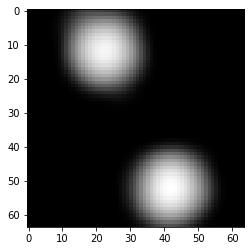

In [619]:
sigma=3
patoms_grid = gauss_forward_model.make_proj_mask(rms[0].T,xy,sigma=sigma,n_trunc=6*sigma,parallel_diff=True)
doplt(np.log(1+patoms_grid))

Final guess

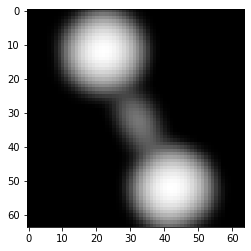

In [620]:
patoms_grid = gauss_forward_model.make_proj_mask(rms[-1].T,xy,sigma=sigma,n_trunc=6*sigma,parallel_diff=True)
doplt(np.log(1+patoms_grid))

With two gaussian blobs and two pseudo atoms, starting from good rm0, by the last iteration the pseudo atoms are brought closer together.

With 125 gaussian blobs, we end up wtih some in the middle (they were not there in the beginning).

With two gaussian blobs and M=50, if we start with an imbalanced rm0, we don't get even by the end of it (more atoms at one blob even though they are the same). By M=500 this is not an issue

|N|sigma|time|M|notes|
|-|-|-|-|-|
|64|3|27s|500|two gaussian blobs, each with a good 10x10 patch of intense areas. more diffuse afterwards|
|64|3|17s|-|precompute rs|
|-|-|11s|250||
|-|-|5.1s|125||
|-|-|2.7s|-|precompute rs|
|-|-|2.9s|75||
|-|-|1.47s|-|precompute rs since independent of t|


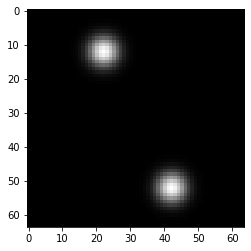

In [555]:
doplt(arr)

# 3D

In [5]:
def make_gauss_3d(xv,yv,zv,mu,sigma):
  g = np.exp(-( (xv-mu[0])**2 + (yv-mu[1])**2 + (zv-mu[2])**2)  /(2*sigma**2) )
  return(g)

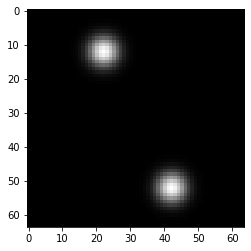

In [6]:
N=64
coords_1d = np.arange(-N//2,N//2)
sigma=3

xyz = coords.coords_n_by_d(coords_1d,d=3)
xyz[:,[0,1]] = xyz[:,[1,0]]
xv,yv,zv = np.meshgrid(coords_1d,coords_1d,coords_1d)
arr = make_gauss_3d(xv,yv,zv,mu=[-10,-20,0],sigma=sigma)
arr += make_gauss_3d(xv,yv,zv,mu=[10,20,0],sigma=sigma)
arr /= arr.sum()
doplt(arr.sum(-1))

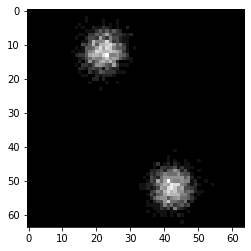

In [41]:
arr_flat = arr.flatten()
arr_idx = np.arange(arr_flat.shape[0])
np.random.seed(1)
M=3000
samples_idx = np.random.choice(arr_idx,size=M,replace=True,p=arr_flat) # replace or not... not sure

arr_empty = np.zeros(N*N*N)
arr_empty[samples_idx]=1
doplt(arr_empty.reshape(N,N,N).sum(-1))

In [43]:
r_idx = np.random.choice(arr_idx,p=arr_flat) 
r = xyz[r_idx]

rm0 = xyz[samples_idx]
dist = np.sqrt(((r - rm0)**2).sum(1)) # usually sum over xyz

# rank = (rankdata(dist)-1).reshape(-1,1)
order = dist.argsort()
rank = order.argsort().reshape(-1,1)

e0=0.3
ef=0.05
l0=0.2*M/3
lf = 0.5
tf = 200*M

d=3
# rms = np.empty((tf+1,M,d))
n_save = 10
rms = np.empty((n_save+1,M,d))
rms[0] = rm0
rs = np.empty((tf+1,d))
ts_save = np.empty((n_save+1))

print('estimated time (s)', 100e-6*tf)

In [53]:
time = %timeit -o order = dist.argsort() ; rank = order.argsort().reshape(-1,1)
print('estimated time (min) %.1f' % (time.best*tf/60))

1000 loops, best of 5: 419 µs per loop
estimated time (min) 4.2


In [44]:
%%time
r_idxs = np.random.choice(arr_idx,p=arr_flat,size=tf)  # can precompute
rm = rm0
save_idx=0
for t in range(tf):
  if t % (tf//n_save) == 0: print(t)
  r_idx = r_idxs[t]
  r = xyz[r_idx]
  rs[t]=r
  dist = np.sqrt(((r - rm)**2).sum(1)) # usually sum over xyz
  # rank = (rankdata(dist)-1).reshape(-1,1)
  order = dist.argsort()
  rank = order.argsort().reshape(-1,1)
  l = l0*(lf/l0)**(t/tf)
  e = e0*(ef/e0)**(t/tf)
  rm = rm + e*np.exp(-rank/l)*(r-rm)
  if (t % (tf//n_save) == 0) or (t == tf-1): 
    rms[save_idx] = rm
    ts_save[save_idx] = t
    save_idx+=1

0
60000
120000
180000
240000
300000
360000
420000
480000
540000


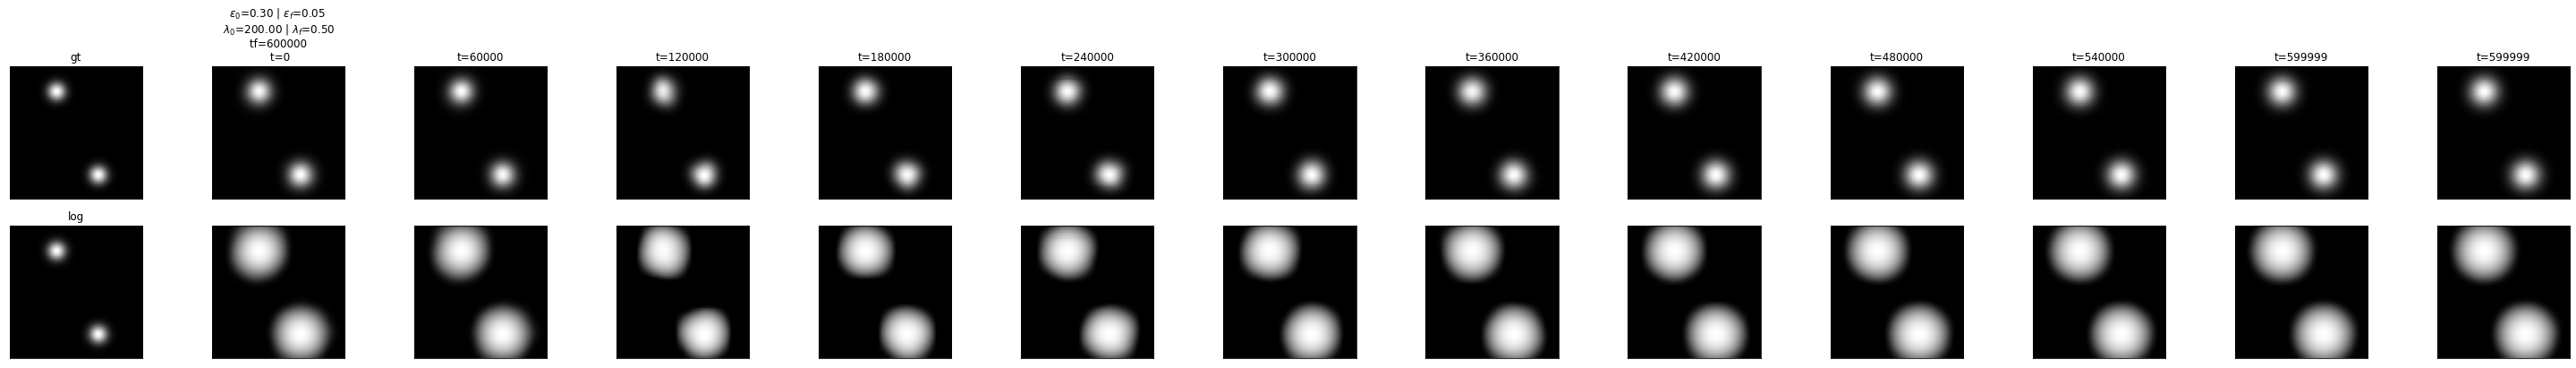

In [56]:
t_d={}
for save_idx,t in enumerate(ts_save):
  t_d[int(t)]=save_idx
  
xy = coords.coords_n_by_d(coords_1d,d=2)
xy[:,[0,1]] = xy[:,[1,0]]

sigma=3
arr_2d = arr.sum(-1)
# ts = [np.nan] + [t for t in range(0,tf,tf//10)] + [-1]
ts = [np.nan] + ts_save.tolist() + [tf-1]

fig,axes = plt.subplots(ncols=len(ts),nrows=2,figsize=(4*len(ts),6))
for idx,t in enumerate(ts):
  if idx == 0:
    patoms_grid = arr_2d
    axes[0,idx].set_title('gt')
    axes[1,idx].set_title('log')
  else:
    patoms_grid = gauss_forward_model.make_proj_mask(rms[t_d[int(t)]].T,xy,sigma=sigma,n_trunc=6*sigma,parallel_diff=True)
  if idx == 1:
    axes[0,idx].set_title('$\epsilon_0$=%.2f | $\epsilon_f$=%.2f \n $\lambda_0$=%.2f | $\lambda_f$=%.2f \n tf=%i \n t=%i'%(e0,ef,l0,lf,tf,t))
  elif idx > 1:
    axes[0,idx].set_title('t=%i'%t)

  axes[0,idx].imshow((patoms_grid),cmap='gray') 
  axes[1,idx].imshow(np.log(patoms_grid+1),cmap='gray')
  for r in [0,1]: axes[r,idx].set_xticks([]) ; axes[r,idx].set_yticks([])


|N|sigma|time|M|notes|
|-|-|-|-|-|
|64|3|17.5s|500|two gaussian blobs, each with a good 10x10 patch of intense areas. more diffuse afterwards. like 2D case, atoms in between|
|-|-|6.4s|250||
|-|-|2.7s|125|two gauss. atoms in between go away when l0 reduced to 50%, but then goes to one ball if reduced to 1/1000, so that l0 < lf. A better l0 is ~33% or lower, so $0.067M$|
|-|-|1.46s|75||

## bottleneck
The bottleneck is computing the ranks (by sorting)

In [11]:
%timeit r_idx = r_idxs[t]
%timeit r = xyz[r_idx]
%timeit rs[t]=r
%timeit dist = np.sqrt(((r - rm)**2).sum(1)) # 31 us
%timeit rank = (rankdata(dist)-1).reshape(-1,1) # 132 us
%timeit l = l0*(lf/l0)**(t/tf)
%timeit e = e0*(ef/e0)**(t/tf)
%timeit rms[t+1] = rms[t] + e*np.exp(-rank/l)*(r-rms[t])
%timeit rm=rms[t+1]

The slowest run took 45.05 times longer than the fastest. This could mean that an intermediate result is being cached.
10000000 loops, best of 5: 169 ns per loop
The slowest run took 23.80 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 5: 305 ns per loop
The slowest run took 124.09 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 5: 591 ns per loop
The slowest run took 40.61 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 5: 30.9 µs per loop
The slowest run took 16.09 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 5: 132 µs per loop
The slowest run took 24.76 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 5: 242 ns per loop
The slowest run took 17.60 times lo

In [19]:
%%timeit
order = dist.argsort()
ranks = order.argsort()

The slowest run took 12.42 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 5: 94.6 µs per loop


In [20]:
%timeit rankdata(dist) # 128 us

The slowest run took 10.13 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 5: 128 µs per loop


95 us argsort beates 132 us rankdata

In [18]:
rank.flatten()[:10], ranks.flatten()[:10]

(array([969. ,  40. , 532. , 520. , 516.5, 995. , 735. , 589. , 873. ,
        360. ]), array([969,  40, 532, 520, 517, 995, 735, 589, 873, 360]))

The rankdata has a nice way of breaking ties, and argsort doesn't have this.

In [ ]:
ranks.flatten() - rank.flatten()